In [ ]:
# standard
import time
import numpy as np
import pandas as pd
from tqdm import tqdm

# sklearn
from sklearn.base import BaseEstimator, TransformerMixin


class IdentityTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, input_array, y=None):
        return self
    
    def transform(self, X, y=None):
        return X


class scheduleDateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    @property
    def output_columns(self):
        return ["dayOfWeek", "hourOfDay"]
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["dayOfWeek"] = X["scheduleDateTime"].dt.dayofweek
        X["hourOfDay"] = X["scheduleDateTime"].dt.hour
        
        return X[self.output_columns]

class categoryImputer(BaseEstimator, TransformerMixin):
    
    def __init__(self, category_columns):
        self._category_columns = category_columns
        
        self._imputer = SimpleImputer(missing_values="nan",
                                      strategy="constant",
                                      fill_value="missing")
        
    @property 
    def category_columns(self):
        return self._category_columns
            
    @property
    def imputer(self):
        return self._imputer
    
    def fit(self, X, y=None):
        X_imputed = self.imputer.fit(X[self.category_columns])
        return self
        
    def transform(self, X, y=None):
        X_imputed = self.imputer.transform(X[self.category_columns])
        X[self.category_columns] = X_imputed
        return X
        
    
features = scheduleDateTransformer().transform(df_x.head())
features

In [1]:
%load_ext autoreload
%autoreload 2

## Feature transformers for KNSB race features [Imputation, Speed moving average, Track position]

In [5]:
# standard
import time
import sys, os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt


# # tsfresh
# from tsfresh.transformers.per_column_imputer import PerColumnImputer
# from tsfresh.utilities.dataframe_functions import impute, get_range_values_per_column, impute_dataframe_range

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import linear_model, decomposition, datasets
from sklearn.preprocessing import StandardScaler, RobustScaler

# catboost
from catboost import Pool
from catboost import CatBoostRegressor

# mlflow
import mlflow

# own modules
sys.path.append("../")
# from src.data.validators import model_output_schema
from src.evaluation.regression import get_regression_metrics
from src.data.google_storage_io import read_csv_data, write_csv_data

# our transformers
# from src.features.transformers.feature_transformers import (PersonalFeatureImputer, 
#                                                             SpeedFeatureTransformer,
#                                                             TrackFeatureTransformer,
#                                                             MainFeatureProcessor)

import warnings
warnings.filterwarnings('ignore')

## Parameters

In [21]:
# input parameters
input_file = "../lvt-schiphol-assignment-snakemake/data/model_input/delays_extended_input.csv"

# personal_features = "gs://knsb-times-data/model_input/features/personal_features.csv"
# credentials = "../../keys/data-access.json"   # point to credentials file

# # output parameters
# output_dir = "../../knsb-times-data/model_output/catboost_pipeline/"

# # model parameters
# n_jobs = -1
# prediction_target = "avg_speed_left"

# # mlflow parameters
# mlflow_credentials = "../../keys/data-access.json"
# mlflow_server = "http://35.204.210.2:5000"
# mlflow_experiment = "Catboost"
# run_suffix = "__chain_estimators"

In [22]:
## Parameters to be logged in mlflow
# PREDICTION_TARGET = prediction_target

In [23]:
df = read_csv_data(input_file)
df = df.drop(columns=["scheduleDateTime", "actualOffBlockTime"]).set_index("id")
print(df.shape)
df.head()

Reading file from local directory
File:	../lvt-schiphol-assignment-snakemake/data/model_input/delays_extended_input.csv

(547692, 19)


aircraftRegistration  airlineCode  terminal serviceType  \
id                                                                           
123414481790510775                PHPXB        148.0       NaN         NaN   
123414479288269149                PHHSJ        164.0       1.0           J   
123414479666542945                PHHSG        100.0       1.0           J   
123414479288365061                PHHSG        164.0       1.0           J   
123414479288274329                PHHXB        164.0       1.0           J   

                    scheduleDelaySeconds  dayofweek  quarter  month  year  \
id                                                                          
123414481790510775                -480.0          0        1      1  2018   
123414479288269149                 -98.0          0        1      1  2018   
123414479666542945                -300.0          0        1      1  2018   
123414479288365061                -300.0          0        1      1  2018   
123414479288274329                 694.0          0        1      1  2018   

                    dayofmonth  weekofyear  hour  minutes final_destination  \
id                                                                            
123414481790510775           1           1     3       30               AMS   
123414479288269149           1           1     6        0               SPC   
123414479666542945           1           1     6        5               LPA   
123414479288365061           1           1     6        5               LPA   
123414479288274329           1           1     6       15               TLV   

                     Latitude  Longitude  Altitude DST  destination_distance  
id                                                                            
123414481790510775  52.308601    4.76389     -11.0   E          4.338444e-07  
123414479288269149  28.626499  -17.75560     107.0   E          3.267980e+01  
123414479666542945  27.931900  -15.38660      78.0   E          3.162698e+01  
123414479288365061  27.931900  -15.38660      78.0   E          3.162698e+01  
123414479288274329  32.011398   34.88670     135.0   E          3.632300e+01

In [11]:
# mae_plot_file = f"{output_dir}/mae_plot.png"
# prediction_output_file = f"{output_dir}/time_predictions.csv"
# pipeline_pickle = f"{output_dir}/pipeline.pkl"
# model_data_picle = f"{output_dir}/model_data.pkl"


# Split and align train/test data

## Prepare minimal input.ipynb_checkpoints/

In [6]:
# read data from google storage 
df_target = read_csv_data(input_target, credentials)

# remove races with single observation
df_target = df_target.groupby("RaceId").filter(lambda x: x.shape[0] > 1)

# add id with RaceId + step
df_target["id"] = df_target["RaceId"].astype(str).str.cat(df_target["step"].astype(str), sep='_')
target_id_mapping = df_target[["id", "RaceId", "step"]]
df_target = df_target.set_index('id')


# read personal+race features from google storage
df_personal = read_csv_data("gs://knsb-times-data/model_input/features/personal_features.csv", credentials)

# cleanup data after loading
df_personal = df_personal.drop(columns=['PersonId']).set_index('RaceId')
df_personal = df_personal.loc[:,~df_personal.columns.str.startswith('Unnamed:')]

df_personal = df_personal.drop(columns=['Female'])
df_personal = df_personal.rename(columns={"Male": "Gender"})
df_personal["Gender"] = df_personal["Gender"].apply(lambda x: 0 if x==0 else 1)


# merge features from minimal model input + personal features
minimal_features = ["step", "Passed", "Loop", "Speed", "seconds"] 

X_features = df_personal \
    .merge(df_target[minimal_features+['RaceId']], on=['RaceId']) 
X_features["id"] = X_features["RaceId"].astype(str).str.cat(X_features["step"].astype(str), sep='_')
X_features = X_features.set_index('id').drop(columns=['RaceId'])


df_target, X_features = df_target.align(X_features, join='inner', axis = 0)
X_features_columns = X_features.columns
df_target.index.name = 'id'
X_features.head()

Reading file from Google Storage
Bucket:	knsb-times-data
File:	model_input/target/minimal_model_input.csv

Reading file from Google Storage
Bucket:	knsb-times-data
File:	model_input/features/personal_features.csv



distance  age_days  PersonalBest  \
id                                                                         
0003a496-8611-4cee-b3b3-54bfe0f6c570_1      3000   10578.0         241.0   
0003a496-8611-4cee-b3b3-54bfe0f6c570_2      3000   10578.0         241.0   
0003a496-8611-4cee-b3b3-54bfe0f6c570_3      3000   10578.0         241.0   
0003a496-8611-4cee-b3b3-54bfe0f6c570_4      3000   10578.0         241.0   
0003a496-8611-4cee-b3b3-54bfe0f6c570_5      3000   10578.0         241.0   

                                        SeasonBest  Lane  Gender  step  \
id                                                                       
0003a496-8611-4cee-b3b3-54bfe0f6c570_1      245.69     1       0     1   
0003a496-8611-4cee-b3b3-54bfe0f6c570_2      245.69     1       0     2   
0003a496-8611-4cee-b3b3-54bfe0f6c570_3      245.69     1       0     3   
0003a496-8611-4cee-b3b3-54bfe0f6c570_4      245.69     1       0     4   
0003a496-8611-4cee-b3b3-54bfe0f6c570_5      245.69     1       0     5   

                                         Passed  Loop   Speed  seconds  
id                                                                      
0003a496-8611-4cee-b3b3-54bfe0f6c570_1   37.204     7   0.000   5.8482  
0003a496-8611-4cee-b3b3-54bfe0f6c570_2   69.143     8   0.000   8.9680  
0003a496-8611-4cee-b3b3-54bfe0f6c570_3  101.082     9  10.639  11.8522  
0003a496-8611-4cee-b3b3-54bfe0f6c570_4  124.082    10  11.461  13.7615  
0003a496-8611-4cee-b3b3-54bfe0f6c570_5  156.366    11  12.251  16.3648

## Train/Test split

Split data into train/test sets. Each `RaceId` must be included entirely in train or test set.

In [263]:
%%time

test_size = 0.3
random_state = 200

# split train/test on entire races
all_race_ids = target_id_mapping["RaceId"].unique()
train_race_ids, test_race_ids = train_test_split(all_race_ids, test_size=test_size, random_state=random_state)
train_ids, test_ids = target_id_mapping.query(f"RaceId in {list(train_race_ids)}")["id"], target_id_mapping.query(f"RaceId in {list(test_race_ids)}")["id"]

# split targets and features on raceId's 
y_train, y_test = df_target.query(f"id in {list(train_ids)}"), df_target.query(f"id in {list(test_ids)}")
X_train, X_test = X_features.query(f"id in {list(train_ids)}"), X_features.query(f"id in {list(test_ids)}")

# add raceid + step as columns from indices for futher preprocessing
X_test['RaceId'], X_test['step'] = X_test.index.str.split('_', 1).str
X_train['RaceId'], X_train['step'] = X_train.index.str.split('_', 1).str

print(f"Splitting data into train/test set with test size: {test_size}" 
      f"\nRace IDs: \t{train_ids.shape[0], test_ids.shape[0]}"
      f"\nObservations:\t{y_train.shape[0], y_test.shape[0]}")

Splitting data into train/test set with test size: 0.3
Race IDs: 	(166108, 72011)
Observations:	(166108, 72011)
Wall time: 16.1 s


# Create Pipeline with CatBoost

In [264]:
class CatBoostChain(BaseEstimator, TransformerMixin):
    """
    Catboost estimator that uses .transform() to append output predictions
    """
    def __init__(self, catboost_kwargs, early_stopping_rounds=None):
        self.catboost = CatBoostRegressor(**catboost_kwargs)
        self.early_stopping_rounds = early_stopping_rounds
        
    def fit(self, X, y, **kwargs):
        """
        Expects 'y' to be the race finish times- not avg_speed_left
        """
        # calculate avg speed left
        y =  ((X["distance"] - X["Passed"]) / (y.values - X["seconds"])) \
            .replace([np.inf, -np.inf], np.nan) \
            .fillna(0).values
    
        X_pool_train, X_pool_eval, y_pool_train, y_pool_eval = train_test_split(X, y, test_size=0.2)

        train_pool = Pool(data=X_pool_train,
                          label=y_pool_train,
                          cat_features=self.catboost.get_param("cat_features"))
#                                   baseline=X_dist_train["yhat_finish_time"])

        eval_pool = Pool(data=X_pool_eval,
                         label=y_pool_eval,
                         cat_features=self.catboost.get_param("cat_features"))
        
        self.catboost.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=self.early_stopping_rounds, **kwargs)
        
        return self
    
    
    def transform(self, X, y=None, **kwargs):
        """
        returns two predictions appended to the input features
        - avg_speed_left
        - finish_time
        """
        yhat = self.predict(X)
        
        # transform to finish time
        yhat_finish_time = X["seconds"] + (X['distance'] - X['Passed']) / yhat
        
        df_yhat = pd.DataFrame({
            "yhat_avg_speed": yhat,
            "yhat_finish_time": yhat_finish_time
        })
        
        return pd.concat([X, df_yhat], axis=1)
    
    
    def predict(self, X):
        return self.catboost.predict(X)
    

# catboost_transformer = CatBoostChain(verbose=0, 
#                                      iterations=100,
#                                      task_type="GPU",
#                                      loss_function='MAE',
#                                      cat_features=['pmap_0', 'pmap_1'])

# # create pipeline
# pipeline = Pipeline(steps=[
#     ('features', MainFeatureProcessor()),
#     ('catboost_base', catboost_transformer)
# ])


# pipeline.named_steps['features'].timeseries_container = X_train
# pipeline.fit_transform(X_train.head(1000), y_train["finish_time"].head(1000))
        

In [265]:
class CatBoostGroupDistance(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 catboost_kwargs={
                     "verbose": 0, 
                     "iterations": 100, 
                     "cat_features": ["pmap_0", "pmap_1"],
                     "loss_function": "MAE"}):
        
        self.distances = [500, 1000, 1500, 3000, 5000, 10000]
        self.race_parts = [1,2,3,4]
        self.race_parts_str = {
            1: "first 100m",
            2: "first half",
            3: "second half",
            4: "last 100m"
        }
        
        self._catboost_models = {(distance, part): CatBoostRegressor(**catboost_kwargs) 
                                 for distance in self.distances 
                                 for part in self.race_parts}
    
    @property
    def catboost_models(self):
        return self._catboost_models
    
    
    def _calculate_race_part(self, passed, distance):
        if passed <= 100:
            race_part = 1    # first 100m
        elif passed < (distance / 2):
            race_part = 2    # first half
        elif (distance - passed) <= 100:
            race_part = 4    # last 100m
        else:
            race_part = 3    # second half
        
        return race_part
    
    def fit(self, X, y, early_stopping_rounds=50):
        """
        Fit model separately by race distance
        """
          
        X["_race_part"] = X[["Passed", "distance"]] \
            .apply(lambda x: self._calculate_race_part(*x), axis=1)

        X_grouped = X.assign(y_target = y.values).groupby(["distance", "_race_part"])
        X_groups = list(X_grouped.indices.keys())
        
        
        for dist in self.distances:
            for race_part in self.race_parts:
                group_tuple = (dist, race_part)
                
                if group_tuple not in X_groups:
                    print(f"Skipping {group_tuple}")
                    continue
                    
                # select model
                current_model = self.catboost_models[group_tuple]
                    
                # prepare train/evaluation data
                X_dist = X_grouped.get_group(group_tuple)
                X_dist, y_dist = X_dist.drop(columns=["y_target"]), X_dist["y_target"]
                X_dist_train, X_dist_eval, y_dist_train, y_dist_eval = train_test_split(X_dist, y_dist, test_size=0.3)
                
                # use evaluation set for early stopping (??)
                train_pool = Pool(data=X_dist_train,
                                  label=y_dist_train,
                                  cat_features=current_model.get_param("cat_features"),
                                  baseline=X_dist_train["yhat_finish_time"])
                
                eval_pool = Pool(data=X_dist_eval,
                                 label=y_dist_eval,
                                 cat_features=current_model.get_param("cat_features"),
                                 baseline=X_dist_eval["yhat_finish_time"])
                
                print(f"Fitting model for {self.race_parts_str[race_part]} of distance {dist} on {X_dist_train.shape[0]} samples")
                current_model.fit(train_pool, early_stopping_rounds=early_stopping_rounds,
                                  eval_set=eval_pool)

        return self
    
    
    def predict(self, X):
        X["_race_part"] = X[["Passed", "distance"]] \
            .apply(lambda x: self._calculate_race_part(*x), axis=1)

        X_grouped = X.groupby(["distance", "_race_part"])
        X_groups = list(X_grouped.indices.keys())
        
        output_predictions = np.array([])
        group_idx = []
        
        for dist in self.distances:
            for race_part in self.race_parts:
                group_tuple = (dist, race_part)
                
                if group_tuple not in X_groups:
                    continue
                
                X_dist = X_grouped.get_group(group_tuple)
                
                group_idx.extend(X_dist.index.values)

                preds = self.catboost_models[group_tuple].predict(X_dist)
#                 preds = preds + X_dist["yhat_finish_time"]
                if "yhat_finish_time" in X.columns:
                    preds = preds + X_dist["yhat_finish_time"]
                
                output_predictions = np.append(output_predictions, preds)

        output_predictions = pd.Series(output_predictions, index=group_idx).reindex(X.index)
        
        return output_predictions

catboost__devices = "0:1"
catboost__loss_function = 'MAE'
catboost__depth = 14
catboost__l2_leaf_reg = 3
catboost__learning_rate = 0.3
    
    
# create pipeline
catboost_transformer = CatBoostChain(
    early_stopping_rounds = 50,
    catboost_kwargs={
        "verbose": 0, 
        "iterations": 500,
        "depth": 10,
        "learning_rate": 0.3,
        "l2_leaf_reg": 4,
        "cat_features": ["pmap_0", "pmap_1"],
        "loss_function": "MAE"}
)

catboost_grouped = CatBoostGroupDistance(
    catboost_kwargs={
        "verbose": 0, 
        "iterations": 200, 
        "l2_leaf_reg": 3,
        "learning_rate": 0.1,
        "cat_features": ["pmap_0", "pmap_1"],
        "loss_function": "MAE"}
)
    
pipeline = Pipeline(steps=[
    ('features', MainFeatureProcessor()),
    ('catboost_base', catboost_transformer),
    ('catboost_distance', catboost_grouped)
])


pipeline.named_steps['features'].timeseries_container = X_train
pipeline.fit(X_train, y_train["finish_time"])
# predict_train = pipeline.predict(X=X_train)        

elapsed before imputing: 0.7389473915100098
elapsed after imputing: 2.3669815063476562
PersonalFeatureInputer elapsed: 2.398982524871826
subsetting input to index
SpeedFeatureTransformer elapsed: 8.349019527435303
TrackFeatureTransformer elapsed: 14.80699896812439
Fitting model for first 100m of distance 500 on 2154 samples
Fitting model for first half of distance 500 on 2886 samples
Fitting model for second half of distance 500 on 2877 samples
Fitting model for last 100m of distance 500 on 2937 samples
Fitting model for first 100m of distance 1000 on 1127 samples
Fitting model for first half of distance 1000 on 6714 samples
Fitting model for second half of distance 1000 on 6703 samples
Fitting model for last 100m of distance 1000 on 2202 samples
Fitting model for first 100m of distance 1500 on 435 samples
Fitting model for first half of distance 1500 on 8500 samples
Fitting model for second half of distance 1500 on 7450 samples
Fitting model for last 100m of distance 1500 on 1617 samp

Pipeline(memory=None,
         steps=[('features',
                 MainFeatureProcessor(personal_features=['RaceId', 'seconds',
                                                         'Passed', 'Speed',
                                                         'Loop', 'distance',
                                                         'age_days',
                                                         'PersonalBest',
                                                         'SeasonBest', 'Lane',
                                                         'Gender'],
                                      position_features=['Lane', 'distance',
                                                         'Passed'],
                                      speed_features=['RaceId', 'seconds',
                                                      'Passed', 'Speed'],
                                      timeseries_container=                                         distance  age_days  PersonalBest  \

## Prediction on train and test data

In [266]:
%%time

## apply to single test sample
# change the `timeseries_container` to include required data for test set
pipeline.named_steps['features'].timeseries_container = X_test
pipeline.predict(X_test.sample(1))

elapsed before imputing: 0.0020494461059570312
elapsed after imputing: 0.016025781631469727
PersonalFeatureInputer elapsed: 0.017999649047851562
subsetting input to index
SpeedFeatureTransformer elapsed: 0.04099726676940918
TrackFeatureTransformer elapsed: 0.001987934112548828
Wall time: 103 ms


0    117.984745
dtype: float64

## Pickle output files for mlflow artifacts

- Pipeline serialized with `joblib`
- Model data or sample thereof 



In [372]:
import joblib, pickle
joblib.dump(pipeline, "pipeline.pkl")

PicklingError: Can't pickle <class 'src.features.transformers.feature_transformers.MainFeatureProcessor'>: it's not the same object as src.features.transformers.feature_transformers.MainFeatureProcessor

## Model performance

In [268]:
df_personal = df_personal.reset_index()

ValueError: cannot insert level_0, already exists

In [269]:
# PREDICTION_TARGET = "finish_time"

# # predict using train and test data
# pipeline.named_steps['features'].timeseries_container = X_train
# predict_train = pipeline.predict(X=X_train)
# pipeline.named_steps['features'].timeseries_container = X_test
# predict_test = pipeline.predict(X=X_test)

In [270]:
df_personal.head()

level_0  index                                RaceId  distance  age_days  \
0        0      0  0f4fd8e5-beb5-4d24-8402-01128c80fae5      5000    8436.0   
1        1      1  66862b2f-c820-4e65-bf93-ab20970e917d      1500    8437.0   
2        2      2  6f63cfbd-7f09-4239-b275-843262b8086d       500    8436.0   
3        3      3  f9d9a854-6151-4165-a967-3271894d5d6a     10000    8409.0   
4        4      4  3646e9ee-9f8f-4cc1-9973-d426b92d9d40      5000    9144.0   

   PersonalBest  SeasonBest  Lane  Gender  
0        391.57      391.57     1       1  
1        112.89      112.89     0       1  
2         38.32       39.34     0       1  
3        827.71         NaN     1       1  
4        374.68      380.85     1       1

In [271]:
def predict_and_evaluate(model, X_train, X_test, y_train, y_test, prediction_target="avg_speed_left"):
    PREDICTION_TARGET = "finish_time"

    # predict using train and test data
    pipeline.named_steps['features'].timeseries_container = X_train
    predict_train = model.predict(X=X_train)

    pipeline.named_steps['features'].timeseries_container = X_test
    predict_test = model.predict(X=X_test)
    
    y_train_last_step = y_train['finish_step']
    y_test_last_step = y_test['finish_step']
    
    
    train_race_ids = [x.split("_")[0] for x in X_train.index]

    df_predict_train = pd.DataFrame({
        "RaceId": train_race_ids,
        "yhat": predict_train.values,
        "y": y_train[prediction_target],
        "current_step": [int(x.split("_")[1]) for x in X_train.index],
        "target_step": y_train_last_step,
        "current_passed": y_train["Passed"],
        "type": "train"
    })

    test_race_ids = [x.split("_")[0] for x in X_test.index]

    df_predict_test = pd.DataFrame({
        "RaceId": test_race_ids,
        "yhat": predict_test.values,
        "y": y_test[prediction_target],
        "current_step": [int(x.split("_")[1]) for x in X_test.index],
        "target_step": y_test_last_step,
        "current_passed": y_test["Passed"],
        "type": "test"
    })

    if prediction_target == "avg_speed_left":
        df_predict_train["yhat"] = X_train["seconds"]+(y_train['distance_left']/df_predict_train['yhat'])
        df_predict_train["y"] = y_train["finish_time"]
        df_predict_test["yhat"] =  X_test["seconds"]+(y_test['distance_left']/df_predict_test['yhat'])
        df_predict_test["y"] = y_test['finish_time']

    if prediction_target == "time_left":
        df_predict_train["yhat"] += X_train["seconds"]
        df_predict_train["y"] += X_train["seconds"]
        df_predict_test["yhat"] += X_test["seconds"]
        df_predict_test["y"] += X_test["seconds"]

        # validate 
        assert all(np.abs(df_predict_train["y"] - y_train["finish_time"]) < 0.00001)
        assert all(np.abs(df_predict_test["y"] - y_test["finish_time"]) < 0.00001)

    df_predict_output = pd.concat([df_predict_train, df_predict_test]).reset_index(drop=True)
    return df_predict_output

In [272]:
%%time
df_predict_output = predict_and_evaluate(pipeline, 
                     X_train, X_test,
                     y_train, y_test,
                     prediction_target="finish_time")
df_predict_output = df_predict_output.merge(df_personal, on=["RaceId"], how="left")

elapsed before imputing: 0.856950044631958
elapsed after imputing: 2.5559465885162354
PersonalFeatureInputer elapsed: 2.572946310043335
subsetting input to index
SpeedFeatureTransformer elapsed: 8.049999237060547
TrackFeatureTransformer elapsed: 14.87394905090332
elapsed before imputing: 0.24600005149841309
elapsed after imputing: 1.3369832038879395
PersonalFeatureInputer elapsed: 1.3439884185791016
subsetting input to index
SpeedFeatureTransformer elapsed: 3.5979747772216797
TrackFeatureTransformer elapsed: 6.308054447174072
Wall time: 41.3 s


In [273]:
# write_csv_data(df_predict_output, prediction_output_file, credentials=credentials)

In [274]:
def bin_values(x, nbins, max=None):
    bins = np.linspace(0, max, nbins)
    bins[-1] = np.inf
    digitized = np.digitize(x, bins)
    
#     print(max, np.unique(digitized))
    return digitized

def bin_predictions(df, distance_nbins):
    df = df.groupby("distance") \
        .apply(lambda x: x.assign(bin=bin_values(x["current_passed"], nbins=distance_nbins[x.name], max=int(x.name)))) \
        .reset_index(drop=True)

    return df

df_predict_output["target_step"] = df_predict_output["target_step"].astype(int)
df_predict_output["distance"] = df_predict_output["distance"].astype(int)
df_predict_output["current_passed"] = df_predict_output["current_passed"].astype(int)
distance_nbins = df_predict_output.groupby(["RaceId", "distance"])["target_step"].max().reset_index() \
    .groupby("distance")["target_step"].apply(lambda x: int(x.astype(int).mean().round())).to_dict()

df_predict_output = bin_predictions(df_predict_output, distance_nbins)
df_predict_output

RaceId        yhat        y  \
0       00593e69-7ec1-4716-8794-8d7488c43d0b   35.345508   35.267   
1       00593e69-7ec1-4716-8794-8d7488c43d0b   35.352096   35.267   
2       00593e69-7ec1-4716-8794-8d7488c43d0b   35.300045   35.267   
3       00593e69-7ec1-4716-8794-8d7488c43d0b   35.305969   35.267   
4       00593e69-7ec1-4716-8794-8d7488c43d0b   35.288004   35.267   
...                                      ...         ...      ...   
238114  ffc97a70-d638-49e4-bd59-5ee5c1b85cd9  773.840342  773.599   
238115  ffc97a70-d638-49e4-bd59-5ee5c1b85cd9  773.503242  773.599   
238116  ffc97a70-d638-49e4-bd59-5ee5c1b85cd9  773.487663  773.599   
238117  ffc97a70-d638-49e4-bd59-5ee5c1b85cd9  773.479803  773.599   
238118  ffc97a70-d638-49e4-bd59-5ee5c1b85cd9  777.634795  773.599   

        current_step  target_step  current_passed   type  level_0  index  \
0                  1           15              24  train     1341   1341   
1                  2           15              56  train     1341   1341   
2                  3           15             100  train     1341   1341   
3                  4           15             111  train     1341   1341   
4                  5           15             139  train     1341   1341   
...              ...          ...             ...    ...      ...    ...   
238114           295          299            9871   test       62     62   
238115           296          299            9903   test       62     62   
238116           297          299            9926   test       62     62   
238117           298          299            9958   test       62     62   
238118           299          299           10002   test       62     62   

        distance  age_days  PersonalBest  SeasonBest  Lane  Gender  bin  
0            500    9304.0         35.38      35.470     0       1    1  
1            500    9304.0         35.38      35.470     0       1    2  
2            500    9304.0         35.38      35.470     0       1    3  
3            500    9304.0         35.38      35.470     0       1    3  
4            500    9304.0         35.38      35.470     0       1    4  
...          ...       ...           ...         ...   ...     ...  ...  
238114     10000   11209.0        761.69     787.637     0       1  284  
238115     10000   11209.0        761.69     787.637     0       1  285  
238116     10000   11209.0        761.69     787.637     0       1  285  
238117     10000   11209.0        761.69     787.637     0       1  286  
238118     10000   11209.0        761.69     787.637     0       1  287  

[238119 rows x 16 columns]

In [275]:
df_predict_output.groupby("distance")["bin"].unique()

distance
500            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
1000     [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 1...
1500     [2, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17,...
3000     [1, 2, 3, 5, 6, 7, 9, 10, 12, 13, 14, 16, 17, ...
5000     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15...
10000    [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
Name: bin, dtype: object

In [276]:
def get_regression_df(yhat, y, list_metrics=None):
    # return regression dictionary as single-row dataframe
    metrics_dict = get_regression_metrics(yhat, y, list_metrics=list_metrics)
    metrics_dict["n"] = len(yhat)
    metrics_df = pd.DataFrame(metrics_dict, index=[0]).reset_index(drop=True)
    return metrics_df


In [296]:
%%time

list_metrics = ["mae", "mape", "rmse"]
group_cols = ["bin", "type", "distance"]

df_metrics = df_predict_output.query("current_step != target_step")\
    .groupby(group_cols) \
    .apply(lambda x: get_regression_df(x["yhat"], x["y"], list_metrics=list_metrics)) \
    .reset_index()

df_metrics = df_metrics[[x for x in df_metrics.columns if not x.startswith("level_") or x.startswith("Unnamed: ")]]

# convert metrics to long-format
metric_cols = [x for x in df_metrics.columns if x not in ["current_step", "type", "distance"]]
df_metrics_long = df_metrics.melt(id_vars=group_cols)
df_metrics_long["variable_id"] = df_metrics_long["variable"] + "_" + df_metrics_long["distance"].map(str) + "_" + df_metrics_long["type"]  
df_metrics_long.head()

Wall time: 1.44 s


bin   type  distance variable      value     variable_id
0    1   test       500      mae   0.335191    mae_500_test
1    1   test      3000      mae   3.384663   mae_3000_test
2    1   test      5000      mae   5.588061   mae_5000_test
3    1   test     10000      mae  14.663009  mae_10000_test
4    1  train       500      mae   0.254365   mae_500_train

In [294]:
# import plotly.express as px
# for dist in df_metrics_long.distance.unique():
    
#     fig = px.line(df_metrics_long.query(f"variable == 'mae' and distance == {dist}"),
#                   x="bin", y="value", facet_row="competition_description", facet_col="distance", color="type",
#                  width=800, height=1200)
# #     fig.update_yaxes(matches=None) 
#     fig.update_xaxes(matches=None) 
#     fig.show()

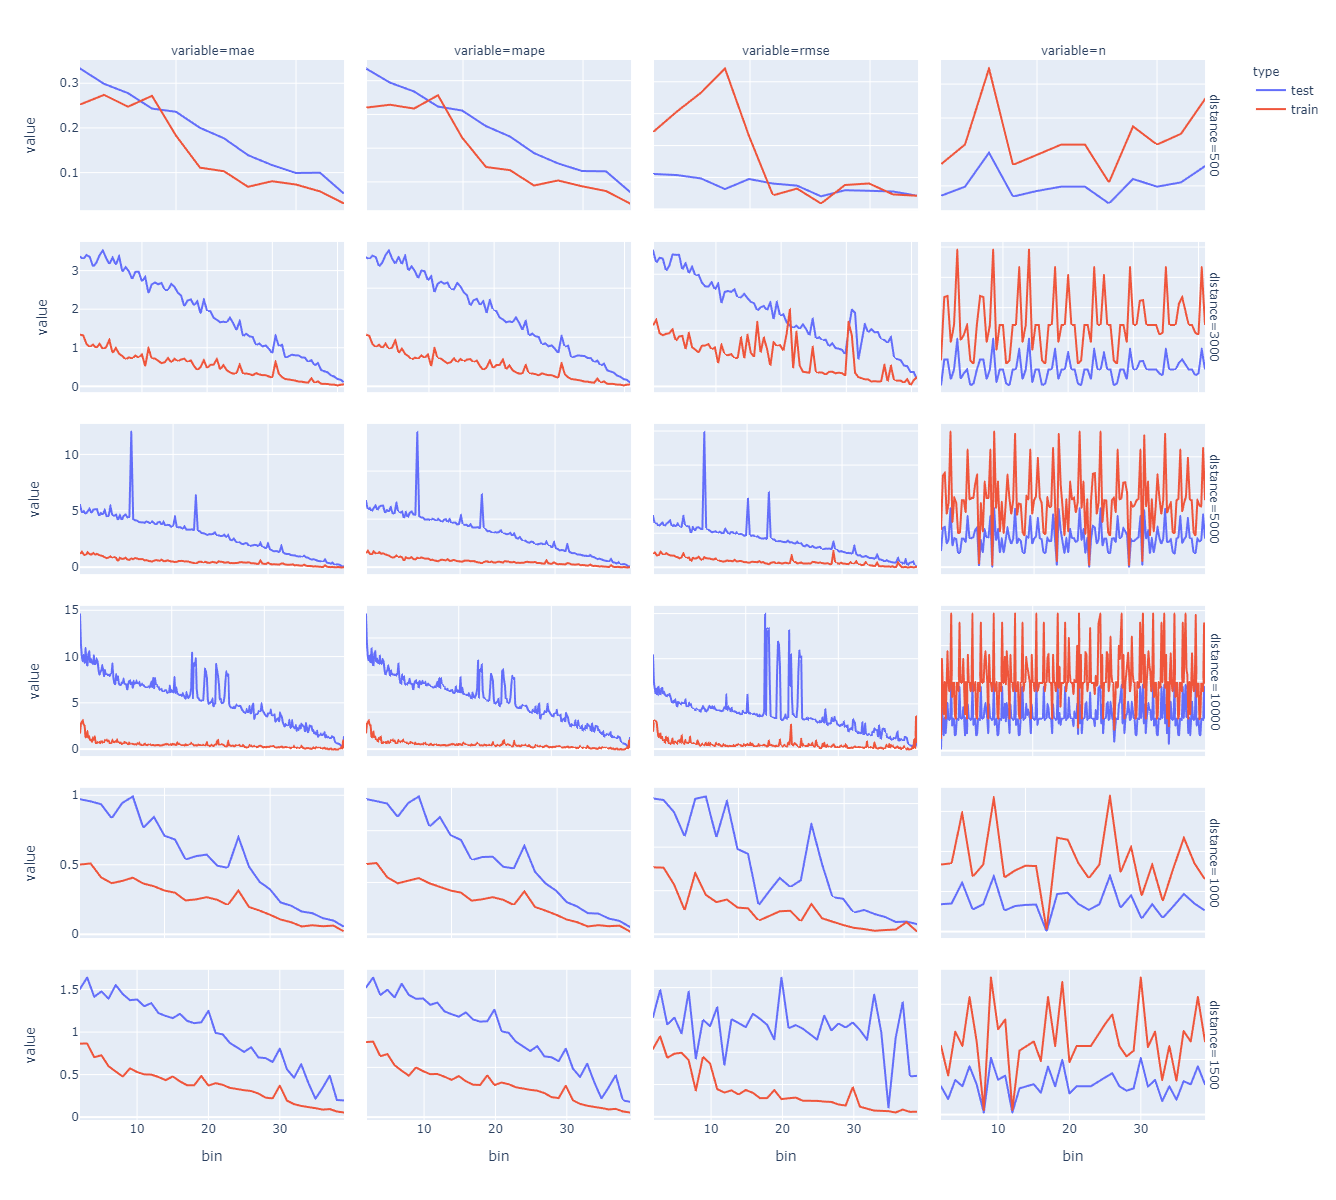

In [297]:
import plotly.express as px
fig = px.line(df_metrics_long, x="bin", y="value", facet_row="distance", facet_col="variable", color="type",
             width=1200, height=1200)
fig.update_yaxes(matches=None) 
fig.update_xaxes(matches=None) 
fig.show()

In [323]:
[f"{dist}m : {variable}" for dist, variable in zip(distances, metric_variables)]

['500m : mae', '3000m : mape', '5000m : rmse', '10000m : n']

In [360]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

distances = sorted(df_metrics_long.distance.unique())
metric_variables = df_metrics_long.variable.unique()

fig = make_subplots(rows=len(distances), cols=len(metric_variables),
                    subplot_titles=[f"{dist}m : {variable}" for dist in distances for variable in metric_variables],
                    horizontal_spacing=0.15 / len(distances), vertical_spacing=0.25 / len(metric_variables),
                    x_title='Passed bin',
                    y_title='Metric value')

for i, distance in enumerate(distances):
    for j, variable in enumerate(metric_variables):
        df_tmp = df_metrics_long.query(f"distance == {distance} and variable == '{variable}'")
        
        df_tmp_test = df_tmp.query("type == 'test'")
        fig.add_trace(
            go.Scatter(x=df_tmp_test.bin, y=df_tmp_test.value,
                       mode='lines',
                       text = [f"distance: {distance}<br>bin: {x:d}<br>{variable}: {y:.2f}<br>type: test" 
                               for x,y in zip(df_tmp_test.bin, df_tmp_test.value)],
                       hoverinfo = 'text',
                        marker=dict(
                            size=5,
                            color='red'
                        ),
                      showlegend=False),
            row=i+1, col=j+1)
        
        df_tmp_train = df_tmp.query("type == 'train'")
        fig.add_trace(
            go.Scatter(x=df_tmp_train.bin, y=df_tmp_train.value,
                       mode='lines',
                       text = [f"distance: {distance}<br>bin: {x:d}<br>{variable}: {y:.2f}<br>type: train" 
                               for x,y in zip(df_tmp_train.bin, df_tmp_train.value)],
                        hoverinfo = 'text',
                        marker=dict(
                            size=5,
                            color='blue'
                        ),
                      showlegend=False),
            row=i+1, col=j+1)
fig.update_layout(width=1800, height=900, title="Chained catboost model evaluation metrics").show()
fig.write_html("prediction_metrics_subplots_plotly.html")

# Plot performance

In [361]:
def calculate_race_part(passed, distance):
        if passed <= 100:
            race_part = 1    # first 100m
        elif passed < (distance / 2):
            race_part = 2    # first half
        elif (distance - passed) <= 100:
            race_part = 4    # last 100m
        else:
            race_part = 3    # second half
        
        return race_part
    
df_predict_output = df_predict_output \
    .assign(race_part=df_predict_output.apply(lambda x: calculate_race_part(x["current_passed"], x["distance"]),axis=1))



In [362]:
df_metadata = df_race[['Category','PersonId','Id','NationalityCode','competition_type', 'competition_description', "DistanceId", "Heat", "Round"]] \
                .rename(columns={"Id":"RaceId"}) \
                .merge(df_person[['Id', 'CountryCode', 'Gender', 'FirstName', 'SurnamePrefix', 'Surname']],
                       left_on=["PersonId"], right_on=['Id'], how="left") \
                .drop_duplicates()
df_metadata.head()

Category                              PersonId  \
0       HN4  21e4c1dc-8905-4db5-8a7a-893b609e0dc8   
4       HN4  21e4c1dc-8905-4db5-8a7a-893b609e0dc8   
8       HN4  21e4c1dc-8905-4db5-8a7a-893b609e0dc8   
12      HN4  eda71de9-9f63-4856-9e44-6188541cd642   
18      HN4  eda71de9-9f63-4856-9e44-6188541cd642   

                                  RaceId NationalityCode competition_type  \
0   0f4fd8e5-beb5-4d24-8402-01128c80fae5             ITA               EK   
4   66862b2f-c820-4e65-bf93-ab20970e917d             ITA               EK   
8   6f63cfbd-7f09-4239-b275-843262b8086d             ITA               EK   
12  9182001c-b464-4f31-9dc7-08130a659765             ITA               EK   
18  427b50a8-61cd-410f-a36d-674ed95360e3             ITA               EK   

                competition_description                            DistanceId  \
0   ISU EK Allround en Sprint - Jan2017  98d35f87-6c06-4f67-a29e-0c683b31ad9d   
4   ISU EK Allround en Sprint - Jan2017  aeb53169-7f80-4a3f-bc2a-7d1babd4d9f6   
8   ISU EK Allround en Sprint - Jan2017  ffb9c379-8f65-4c61-af4c-9f7d87c39a61   
12  ISU EK Allround en Sprint - Jan2017  98d35f87-6c06-4f67-a29e-0c683b31ad9d   
18  ISU EK Allround en Sprint - Jan2017  aeb53169-7f80-4a3f-bc2a-7d1babd4d9f6   

    Heat  Round                                    Id CountryCode Gender  \
0      7      1  21e4c1dc-8905-4db5-8a7a-893b609e0dc8         NaN   Male   
4      3      1  21e4c1dc-8905-4db5-8a7a-893b609e0dc8         NaN   Male   
8      3      1  21e4c1dc-8905-4db5-8a7a-893b609e0dc8         NaN   Male   
12    10      1  eda71de9-9f63-4856-9e44-6188541cd642         NaN   Male   
18    10      1  eda71de9-9f63-4856-9e44-6188541cd642         NaN   Male   

   FirstName SurnamePrefix     Surname  
0     Davide           NaN     Ghiotto  
4     Davide           NaN     Ghiotto  
8     Davide           NaN     Ghiotto  
12    Andrea           NaN  Giovannini  
18    Andrea           NaN  Giovannini

In [284]:
df_predict_output = df_predict_output \
    .merge(df_metadata.drop(columns=["Gender"]), on=["RaceId"], how="left")
df_predict_output["HeatId"] = df_predict_output[["DistanceId", "Heat", "Round"]].astype(str).add('_').sum(axis=1).str[:-1]
df_predict_output.head()

RaceId       yhat       y  current_step  \
0  00593e69-7ec1-4716-8794-8d7488c43d0b  35.345508  35.267             1   
1  00593e69-7ec1-4716-8794-8d7488c43d0b  35.352096  35.267             2   
2  00593e69-7ec1-4716-8794-8d7488c43d0b  35.300045  35.267             3   
3  00593e69-7ec1-4716-8794-8d7488c43d0b  35.305969  35.267             4   
4  00593e69-7ec1-4716-8794-8d7488c43d0b  35.288004  35.267             5   

   target_step  current_passed   type  level_0  index  distance  ...  \
0           15              24  train     1341   1341       500  ...   
1           15              56  train     1341   1341       500  ...   
2           15             100  train     1341   1341       500  ...   
3           15             111  train     1341   1341       500  ...   
4           15             139  train     1341   1341       500  ...   

                            competition_description  \
0  KPN Nederlands Kampioenschap Afstanden - Dec2018   
1  KPN Nederlands Kampioenschap Afstanden - Dec2018   
2  KPN Nederlands Kampioenschap Afstanden - Dec2018   
3  KPN Nederlands Kampioenschap Afstanden - Dec2018   
4  KPN Nederlands Kampioenschap Afstanden - Dec2018   

                             DistanceId  Heat  Round  \
0  f7fbfb5a-0038-49a7-94e8-0493f40c9d03     6      1   
1  f7fbfb5a-0038-49a7-94e8-0493f40c9d03     6      1   
2  f7fbfb5a-0038-49a7-94e8-0493f40c9d03     6      1   
3  f7fbfb5a-0038-49a7-94e8-0493f40c9d03     6      1   
4  f7fbfb5a-0038-49a7-94e8-0493f40c9d03     6      1   

                                     Id  CountryCode  FirstName SurnamePrefix  \
0  1290b4dd-2754-4217-ba20-20a0c07b24bd          NED    Lennart           NaN   
1  1290b4dd-2754-4217-ba20-20a0c07b24bd          NED    Lennart           NaN   
2  1290b4dd-2754-4217-ba20-20a0c07b24bd          NED    Lennart           NaN   
3  1290b4dd-2754-4217-ba20-20a0c07b24bd          NED    Lennart           NaN   
4  1290b4dd-2754-4217-ba20-20a0c07b24bd          NED    Lennart           NaN   

  Surname                                    HeatId  
0  Velema  f7fbfb5a-0038-49a7-94e8-0493f40c9d03_6_1  
1  Velema  f7fbfb5a-0038-49a7-94e8-0493f40c9d03_6_1  
2  Velema  f7fbfb5a-0038-49a7-94e8-0493f40c9d03_6_1  
3  Velema  f7fbfb5a-0038-49a7-94e8-0493f40c9d03_6_1  
4  Velema  f7fbfb5a-0038-49a7-94e8-0493f40c9d03_6_1  

[5 rows x 31 columns]

In [371]:
df_predict_output.to_csv("time_predictions_metadata.csv", index=False)

In [364]:

df_below_personalbest = df_predict_output.query("yhat < PersonalBest")[["RaceId","distance","yhat","y","current_passed", "PersonalBest", "type"]] \
    .eval("best_diff_y = y - PersonalBest") \
    .eval("best_diff_yhat = yhat - PersonalBest") \
    .sort_values("current_passed")
df_below_personalbest

RaceId  distance         yhat        y  \
142719  7b1a0d2d-87d8-4e4d-a43b-07ef5de284d8      5000   423.042815  422.594   
227606  30323bd9-0ea8-49b1-8dc9-a6264271262f     10000   803.866617  839.641   
210581  8977299e-8db5-4a00-b251-4654482ffd42     10000   789.563189  794.395   
209110  7cf3a445-54c8-4d99-b28f-3888dc4674d2     10000   796.509585  796.561   
200944  3e088435-8711-472b-8103-eb8f8af919bc     10000   789.796929  789.505   
...                                      ...       ...          ...      ...   
236922  f5c0ae50-d08b-4fa9-85f9-23334aac24d3     10000   816.470703  832.953   
224192  f9d9a854-6151-4165-a967-3271894d5d6a     10000   785.775195  801.301   
202364  4ca90c32-288a-4319-9a27-d6424be0dfeb     10000 -9385.449988  781.930   
220778  eb44dff3-88c8-4695-ab96-069e6d381089     10000   489.435692  786.149   
225911  1387c7ec-5221-42b8-b178-4734175de7f2     10000   803.076155  808.109   

        current_passed  PersonalBest   type  best_diff_y  best_diff_yhat  
142719               0       424.200  train       -1.606       -1.157185  
227606              11       916.950   test      -77.309     -113.083383  
210581              11       912.670  train     -118.275     -123.106811  
209110              11       812.862  train      -16.301      -16.352415  
200944              11       793.790  train       -4.285       -3.993071  
...                ...           ...    ...          ...             ...  
236922           10002       820.160   test       12.793       -3.689297  
224192           10002       827.710  train      -26.409      -41.934805  
202364           10002       763.570  train       18.360   -10149.019988  
220778           10002       775.010  train       11.139     -285.574308  
225911           10002       821.030   test      -12.921      -17.953845  

[43239 rows x 9 columns]

In [365]:
sum(df_below_personalbest.y < df_below_personalbest.PersonalBest)

38826

In [366]:
import seaborn as sns

In [367]:
list(df_below_personalbest.groupby("RaceId"))[1][1]

RaceId  distance        yhat        y  \
56298  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.035916  112.422   
56299  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.260097  112.422   
56301  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.303235  112.422   
56307  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.184764  112.422   
56310  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.179632  112.422   
56314  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.286982  112.422   
56328  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.350030  112.422   
56330  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.294178  112.422   
56331  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.259412  112.422   
56332  002ddd8f-d268-4351-8132-58f37e9bf9fa      1500  112.318752  112.422   

       current_passed  PersonalBest   type  best_diff_y  best_diff_yhat  
56298              62        112.36  train        0.062       -0.324084  
56299             117        112.36  train        0.062       -0.099903  
56301             173        112.36  train        0.062       -0.056765  
56307             339        112.36  train        0.062       -0.175236  
56310             450        112.36  train        0.062       -0.180368  
56314             601        112.36  train        0.062       -0.073018  
56328            1056        112.36  train        0.062       -0.009970  
56330            1111        112.36  train        0.062       -0.065822  
56331            1139        112.36  train        0.062       -0.100588  
56332            1167        112.36  train        0.062       -0.041248

In [368]:
df_tmp = list(df_below_personalbest.groupby("RaceId"))[100][1]
df_tmp.plot(x="current_passed", y="yhat")
plt.plot(df_tmp.current_passed, df_tmp.y, label="y")
plt.plot(df_tmp.current_passed, df_tmp.PersonalBest, label="PR")
plt.legend()

-8.23633289894036
-0.0295058317072872



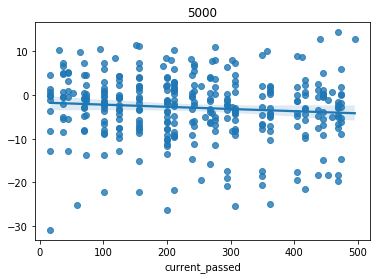

-2.9040476881218997
-0.016175646781884573



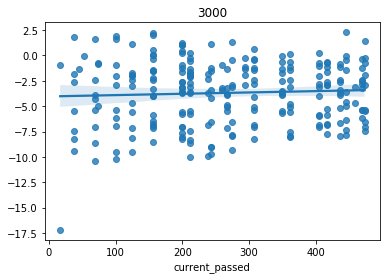

-3.6884180669305953
-0.00936576287792095



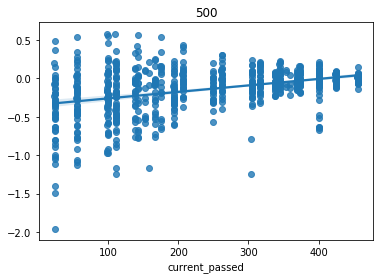

-0.14100713180321242
-0.005174551648018568



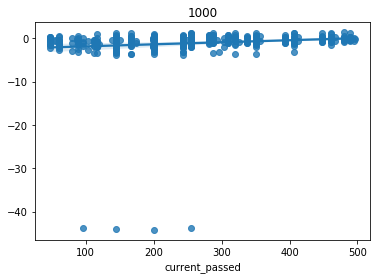

-1.1289774055739452
-0.0052998464645884445



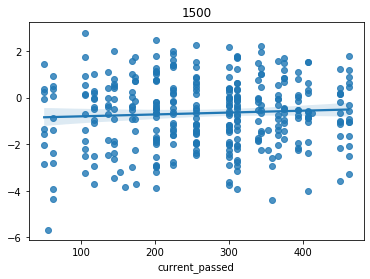

-0.6673539836803312
-0.0063184744399469315



In [369]:
df_below_personalbest = df_below_personalbest.query("current_passed < 500") \
    .sort_values("current_passed") \
    .query("type == 'test'")

df_below_personalbest = df_below_personalbest \
    .assign()

for dist in df_below_personalbest.distance.unique():
    df_tmp = df_below_personalbest.query(f"distance == {dist}").query("best_diff_yhat > -120 and current_passed < distance-10")
#     plt.plot(df_below_personalbest.current_passed, df_below_personalbest.best_diff_yhat)
#     plt.plot(df_tmp.best_diff_yhat, df_tmp.best_diff_y)
    
# #     plt.xlim(-120, 0)
#     plt.show()
#     plt.scatter(df_tmp.current_passed, df_tmp.best_diff_yhat - df_tmp.best_diff_y)
    sns.regplot(df_tmp.current_passed, df_tmp.yhat - df_tmp.y)
#     sns.regplot(df_tmp.current_passed, df_tmp.best_diff_y, color='red')
    plt.title(dist)
    plt.show()
    print(np.mean(df_tmp.best_diff_yhat - df_tmp.best_diff_y))
    print(np.mean(df_tmp.best_diff_yhat / df_tmp.PersonalBest))
    print()

In [370]:
df_race.columns

Index(['Unnamed: 0', 'data_id', 'competition_type', 'competition_description',
       'Color', 'Added', 'Category', 'DistanceCombinations', 'EntityId',
       'Gender', 'Id', 'LicenseDiscipline', 'LicenseFlags', 'LicenseKey',
       'ListId', 'NationalityCode', 'ShortName', 'Source', 'StartNumber',
       'Status', 'FirstName', 'Surname', 'PersonId', 'CompetitorId',
       'DistanceId', 'Heat', 'Lane', 'Laps', 'Passings', 'PersonalBest',
       'PresentedInstanceName', 'Results', 'Round', 'SeasonBest', 'Times',
       'From', 'ClubCode', 'ClubCountryCode', 'ClubFullName', 'ClubShortName',
       'VenueCode', 'SurnamePrefix', 'Initials', 'Transponder1',
       'Transponder2', 'Name', 'Members', 'HeatId'],
      dtype='object')

In [ ]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Scatter(x=[1, 2, 3], y=[4, 5, 6]),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=[20, 30, 40], y=[50, 60, 70]),
    row=1, col=2
)

fig.update_layout(height=600, width=800, title_text="Subplots")
fig.show()

In [23]:
df_metrics_long.groupby(["distance", "variable"])plot(x="bin", y="value")

SyntaxError: invalid syntax (<ipython-input-23-8c92cfcd1e03>, line 1)

In [ ]:
df_metrics = df_output_mlflow.groupby(group_cols) \
    .apply(lambda x: get_regression_df(x["yhat"], x["y"], list_metrics=list_metrics)) \
    .reset_index()

df_metrics = df_metrics[[x for x in df_metrics.columns if not x.startswith("level_") or x.startswith("Unnamed: ")]]
df_metrics.head()

# convert metrics to long-format
metric_cols = [x for x in df_metrics.columns if x not in ["current_step", "type", "distance"]]
df_metrics_long = df_metrics.melt(id_vars=group_cols)
df_metrics_long["variable"] = df_metrics_long["variable"] + "_" + df_metrics_long["distance"].map(str) + "_" + df_metrics_long["type"]  
df_metrics_long.head()

In [19]:
df_output_mlflow.query("distance == 500")["RaceId"].unique()

array(['00799515-526d-4d5c-8ef7-5b20a5670606',
       '00ba8486-837a-4946-9c56-35b65dc9f3ea',
       '00be7481-4818-4cf4-b6aa-219a2e4170b0', ...,
       'fdfbccaf-0cdb-46f7-a85a-32281a08d440',
       'ff57b992-2417-4daf-b29f-674d0f84b241',
       'ffee504b-7a47-4d04-bf62-0bbcc49949fe'], dtype=object)

In [20]:
df_output_mlflow.query("RaceId == '94ff6e67-6fba-4cac-9303-b806f0c2ef5c'")[["current_passed", "y", "yhat"]]

current_passed      y       yhat
93133          23.000  34.69  34.982030
93134          55.210  34.69  34.949868
93135          98.870  34.69  34.940056
93136         110.420  34.69  35.007007
93137         142.365  34.69  35.052849
93138         174.310  34.69  34.885554
93139         206.255  34.69  34.898359
93140         261.465  34.69  34.876134
93141         316.675  34.69  34.899046
93142         344.450  34.69  34.806822
93143         372.225  34.69  34.788598
93144         400.000  34.69  34.834836
93145         423.000  34.69  34.773607
93146         455.210  34.69  34.713950
93147         498.870  34.69  34.911409

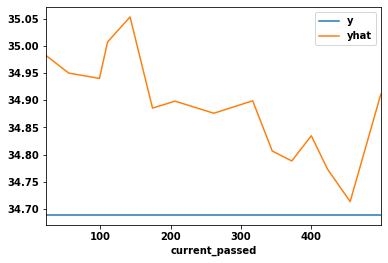

In [21]:
df_output_mlflow.query("RaceId == '94ff6e67-6fba-4cac-9303-b806f0c2ef5c'")[["current_passed", "y", "yhat"]].plot(x="current_passed")

In [22]:
X_train.query("RaceId == '94ff6e67-6fba-4cac-9303-b806f0c2ef5c'")

distance  age_days  PersonalBest  \
id                                                                          
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_1        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_2        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_3        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_4        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_5        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_6        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_7        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_8        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_9        500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_10       500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_11       500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_12       500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_13       500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_14       500   11566.0         34.08   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_15       500   11566.0         34.08   

                                         SeasonBest  Lane  Gender step  \
id                                                                       
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_1        35.06     1       1    1   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_2        35.06     1       1    2   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_3        35.06     1       1    3   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_4        35.06     1       1    4   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_5        35.06     1       1    5   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_6        35.06     1       1    6   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_7        35.06     1       1    7   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_8        35.06     1       1    8   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_9        35.06     1       1    9   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_10       35.06     1       1   10   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_11       35.06     1       1   11   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_12       35.06     1       1   12   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_13       35.06     1       1   13   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_14       35.06     1       1   14   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_15       35.06     1       1   15   

                                          Passed  Loop   Speed  seconds  \
id                                                                        
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_1    23.000    11   0.000   3.7028   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_2    55.210    12   0.000   6.4447   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_3    98.870     1  12.769   9.6375   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_4   110.420     2  13.795  10.4467   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_5   142.365     3  14.844  12.5743   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_6   174.310     4  15.553  14.5545   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_7   206.255     5  16.147  16.5309   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_8   261.465     6  16.257  19.9153   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_9   316.675     7  16.417  23.2567   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_10  344.450     8  16.364  24.9862   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_11  372.225     9  16.298  26.6649   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_12  400.000    10  15.842  28.4927   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_13  423.000    11  15.573  29.9253   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_14  455.210    12  15.987  31.9460   
94ff6e67-6fba-4cac-9303-b806f0c2ef5c_15  498.870     1  15.928  34.6900   

                                                                       RaceId  
id                                                                             
94ff6e67-6fba-4cac-9303-b806f0c2ef5c

In [23]:
pipeline.named_steps['features'].timeseries_container = X_train
# pipeline.predict(X_train.sample(1))
pipeline[:-1].transform(X_train.iloc[93140:93148])

PersonalFeatureInputer step... elapsed before imputing: 0.003002166748046875
elapsed after imputing: 0.019001007080078125
8 8
elapsed: 0.02201104164123535
SpeedFeatureTransformer step... subsetting input to index
data shape:  (12, 4)  target_with_ma shape:  (12, 7)
elapsed: 0.04799771308898926
TrackFeatureTransformer step... elapsed: 0.003999471664428711


seconds   Passed   Speed  Loop  distance  age_days  PersonalBest  \
0  19.9153  261.465  16.257     6       500   11566.0         34.08   
1  23.2567  316.675  16.417     7       500   11566.0         34.08   
2  24.9862  344.450  16.364     8       500   11566.0         34.08   
3  26.6649  372.225  16.298     9       500   11566.0         34.08   
4  28.4927  400.000  15.842    10       500   11566.0         34.08   
5  29.9253  423.000  15.573    11       500   11566.0         34.08   
6  31.9460  455.210  15.987    12       500   11566.0         34.08   
7  34.6900  498.870  15.928     1       500   11566.0         34.08   

   SeasonBest  Lane  Gender  ...     MA_2    MA_1                      pmap_0  \
0       35.06     1       1  ...  16.2020  16.257  STRAIGHT_LINE_INTERSECTION   
1       35.06     1       1  ...  16.3370  16.417  STRAIGHT_LINE_INTERSECTION   
2       35.06     1       1  ...  16.3905  16.364                  CURVE_LEFT   
3       35.06     1       1  ...  16.3310  16.298                  CURVE_LEFT   
4       35.06     1       1  ...  16.0700  15.842                  CURVE_LEFT   
5       35.06     1       1  ...  15.7075  15.573        STRAIGHT_LINE_FINISH   
6       35.06     1       1  ...  15.7800  15.987        STRAIGHT_LINE_FINISH   
7       35.06     1       1  ...  15.9575  15.928        STRAIGHT_LINE_FINISH   

   pmap_1 finish_lane current_lane  position_remainder  lap_distance_left  \
0   inner           0            0              56.399            238.535   
1   inner           0            0               1.189            183.325   
2   inner           0            0              56.664            155.550   
3   inner           0            0              28.889            127.775   
4   inner           0            0               1.114            100.000   
5   inner           0            0              77.000             77.000   
6   inner           0            0              44.790             44.790   
7   inner           0            0               1.130              1.130   

   yhat_avg_speed  yhat_finish_time  
0       15.986014         34.836781  
1       15.830501         34.837193  
2       15.883404         34.779441  
3       15.803513         34.750128  
4       15.776272         34.831333  
5       15.881056         34.773844  
6       16.170543         34.715851  
7       -0.329040         31.255767  

[8 rows x 22 columns]

In [24]:
(df_output_mlflow["yhat"] - df_output_mlflow["y"]).sort_values()

219999   -1277.244357
57753     -548.160024
64451     -475.347412
176236    -382.298080
236613    -351.668047
             ...     
99198      300.691647
136777     323.740632
163484     479.681462
69155      564.229021
150221     688.630755
Length: 238119, dtype: float64

### Plot MAE

In [25]:
run_name = f"catboost__{run_suffix}"

NameError: name 'run_name' is not defined

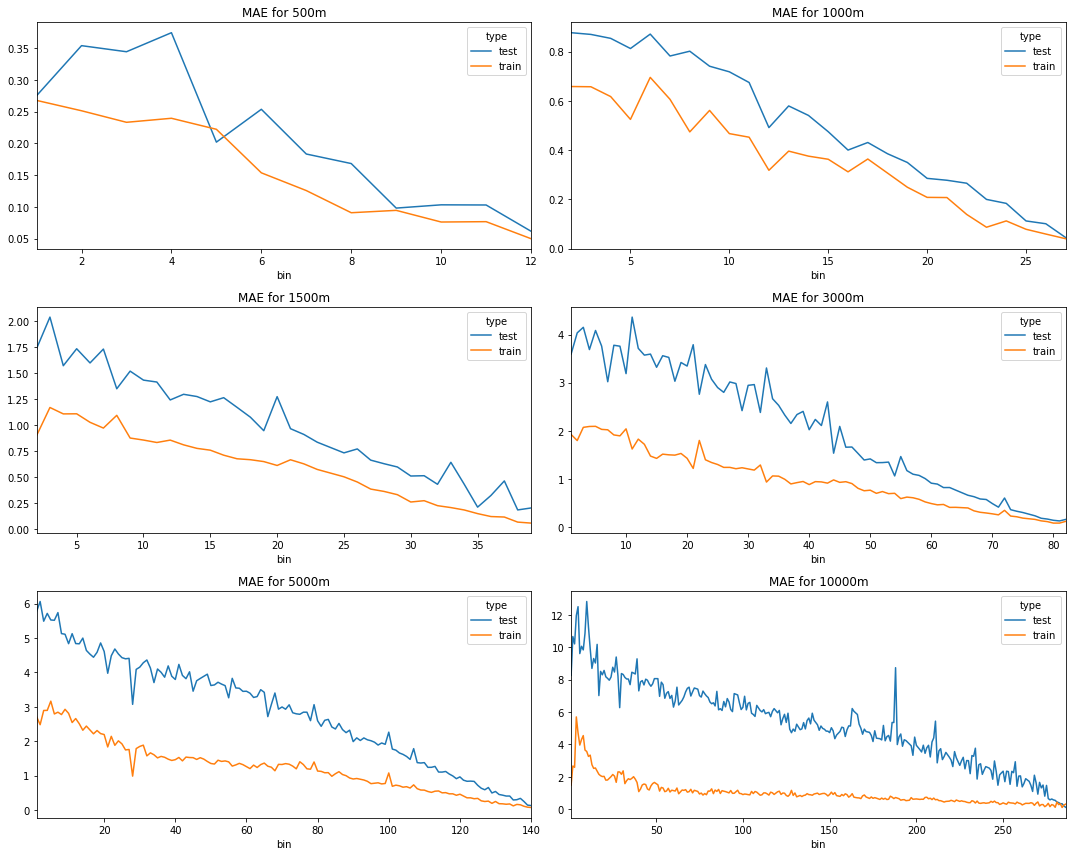

In [138]:
df_metrics_long_plot_groups = list(df_metrics_long \
    .query("variable.str.contains('mae')") \
    .drop(columns=['variable']) \
    .pivot_table(index=['bin', 'distance'],
                columns='type', values='value') \
    .reset_index() \
    .groupby("distance"))

fig, axs = plt.subplots(int(np.ceil(len(df_metrics_long_plot_groups) / 2)), 2,
                        figsize=(15, 12), )

for i, (group_distance, df_distance) in enumerate(df_metrics_long_plot_groups):
    df_distance.drop(columns=['distance']) \
        .plot(x='bin', 
              title=f"MAE for {group_distance}m",
             ax=axs.flatten()[i])

plt.tight_layout()

plt.suptitle(f"{mlflow_experiment}: {run_name}", y=1.02)

plt.savefig(mae_plot_file, bbox_inches='tight')

## Plot error distribution per observation

In [27]:
def quantile_error(y_true, y_pred, q=0.95): 
    errors = (y_pred - y_true)
    return np.quantile(errors, q)

In [28]:
df_error_spread = df_output_mlflow.query("type=='test'").groupby(["distance","current_step","type"]) \
    .apply(lambda df_group: pd.DataFrame({
        "q05": quantile_error(df_group["y"], df_group["yhat"], q=0.05),
        "mean": np.mean(df_group["yhat"] - df_group["y"]),
        "q95": quantile_error(df_group["y"], df_group["yhat"], q=0.95)}, index=[df_group.name]))
df_error_spread = df_error_spread.reset_index(level=[0,1,2]).reset_index(drop=True)

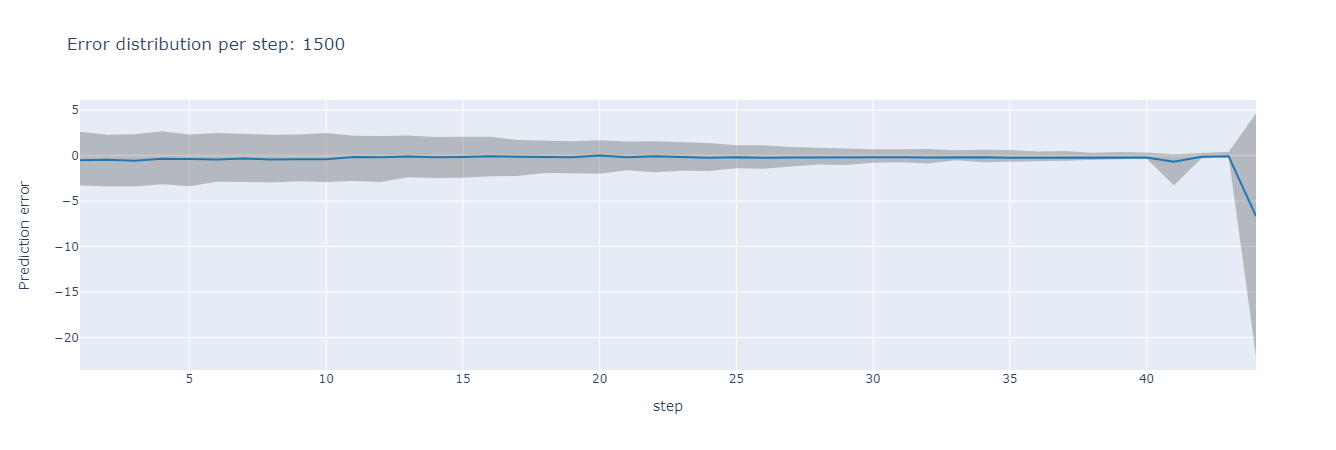

In [29]:
import plotly.graph_objects as go

for group_vals, df_group in list(df_error_spread.groupby(["distance"])):    
    df_error_spread_plot = df_group
    upper_bound = go.Scatter(
        name='5% percentile',
        x=df_error_spread_plot["current_step"],
        y=df_error_spread_plot["q05"],
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    trace = go.Scatter(
        name='Mean',
        x=df_error_spread_plot["current_step"],
        y=df_error_spread_plot["mean"],
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    lower_bound = go.Scatter(
        name='95% percentile',
        x=df_error_spread_plot["current_step"],
        y=df_error_spread_plot["q95"],
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    # Trace order can be important
    # with continuous error bars
    data = [lower_bound, trace, upper_bound]

    layout = go.Layout(
        yaxis=dict(title="Prediction error"),
        xaxis=dict(title="step"),
        title=f'Error distribution per step: {group_vals}',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    fig.show()
    
#     fig.write_image(f"{output_dir}/ED_{group_vals}.png")

## Connect MLFlow

In [30]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.abspath(mlflow_credentials)

# connect mlflow server
mlflow.set_tracking_uri(mlflow_server)
mlflow.set_experiment(mlflow_experiment)

## Log metrics and artifacts to mlflow

In [31]:
mae_plot_file = f"{output_dir}/mae_plot.png"
prediction_output_file = f"{output_dir}/time_predictions.csv"
pipeline_pickle = f"{output_dir}/pipeline.pkl"


In [32]:
# print(f"Logging to experiment: {mlflow_experiment}")
# print(f"Run name: {run_name}")

# with mlflow.start_run(run_name=run_name):
#     # Model metadata
#     mlflow.log_param('prediction_target',PREDICTION_TARGET)
#     mlflow.log_param('target_data',target_data)
#     mlflow.log_params(pipeline[-1].get_all_params())
    
#     # log artifacts
# #     for d in df_error_spread['distance'].unique():
# #         mlflow.log_artifact(f"{output_dir}/ED_{d}.png")

    
#     mlflow.log_artifact(mae_plot_file)
#     mlflow.log_artifact(prediction_output_file)
#     mlflow.log_artifact(pipeline_pickle)
    
#     # Model performance metrics
#     for step, step_metrics in tqdm(df_metrics_long.groupby("current_step")):
#         metrics_dict = dict(zip(step_metrics["variable"], step_metrics["value"]))
#         #metrics_dict = row.to_dict()
#         mlflow.log_metrics(metrics=metrics_dict, step=step)